# Plotting notebook
This is the main notebook we used to get the results we presented in the presentation.

In [1]:
from group_formations import get_xy_data_grouped_by_formation

xy_by_formation = get_xy_data_grouped_by_formation(include_subs=True)

Processed home team for match: 1. FC Köln:FC Bayern München with lineup 4-2-3-1
Processed away team for match: 1. FC Köln:FC Bayern München with lineup 4-2-3-1
Processed home team for match: VfL Bochum 1848:Bayer 04 Leverkusen with lineup 4-3-3 Double-6
Processed away team for match: VfL Bochum 1848:Bayer 04 Leverkusen with lineup 4-2-3-1
Processed home team for match: Fortuna Düsseldorf:FC St. Pauli with lineup 3-4-1-2
Processed away team for match: Fortuna Düsseldorf:FC St. Pauli with lineup 3-3-2-2
Processed home team for match: Fortuna Düsseldorf:1. FC Kaiserslautern with lineup 4-4-2 Double-6 offensive Outliner
Processed away team for match: Fortuna Düsseldorf:1. FC Kaiserslautern with lineup 4-2-3-1
Processed home team for match: Fortuna Düsseldorf:1. FC Nürnberg with lineup 4-2-3-1
Processed away team for match: Fortuna Düsseldorf:1. FC Nürnberg with lineup 4-1-3-2
Processed home team for match: Fortuna Düsseldorf:SSV Jahn Regensburg with lineup 4-2-3-1
Processed away team for m

## Validate there are always exactly 22 players

In [3]:
import numpy as np

XY = xy_by_formation['4-2-3-1']
# XY = xy_by_formation['3-3-2-2']
distinct_lens = {}
for xy in XY:
    l = len(xy)
    if l in distinct_lens:
        distinct_lens[l] += 1
    else:
        distinct_lens[l] = 1

print(distinct_lens)

# temp fix, drop all frames with 24 players
# XY = [xy for xy in XY if len(xy) == 22]
XY = np.array(XY)

{22: 1143480}


## Extract the roles

Number of players: 11
Number of roles (K): 11
Number of bins (L): 294
Grid shape: (14, 21)
Reconstruction error: 0.1046

Player role assignments (dominant role per player):
[ 1  4  7  2  0 10 10  3  5  9  6]


In [ ]:
# Main cell for computing and aggregating player coordinates, per match formation
import os
import pandas as pd
import numpy as np

# Imports and deactivate warnings
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from floodlight.io.dfl import read_position_data_xml
from roles import extract_roles, get_role_heatmaps

path = "data/"
info_files = [x for x in os.listdir(path) if "matchinformation" in x]
position_files = [x for x in os.listdir(path) if "positions_raw" in x]
# Get any pitch attribute, for plotting
_, _, _, _, pitch = read_position_data_xml(os.path.join(path, position_files[0]), os.path.join(path, info_files[0]))

# Get the roles for each team
results = extract_roles(
    XY,  # Convert DataFrame to numpy array
    pitch_xlim=(-52.5, 52.5),
    pitch_ylim=(-34.0, 34.0),
    bin_size=5.0,  # 5m x 5m
    sigma=1.0,  # Gaussian smoothing parameter
    n_roles=11,  # Number of latent roles
    max_iter=500,
    random_state=42,
)

# Display results summary
print(f"Number of players: {results['n_players']}")
print(f"Number of roles (K): {results['n_roles']}")
print(f"Number of bins (L): {results['n_bins']}")
print(f"Grid shape: {results['grid_shape']}")
print(f"Reconstruction error: {results['reconstruction_error']:.4f}")
print(f"\nPlayer role assignments (dominant role per player):")
print(results['player_role_assignments'])

## Overlay all roles in one plot

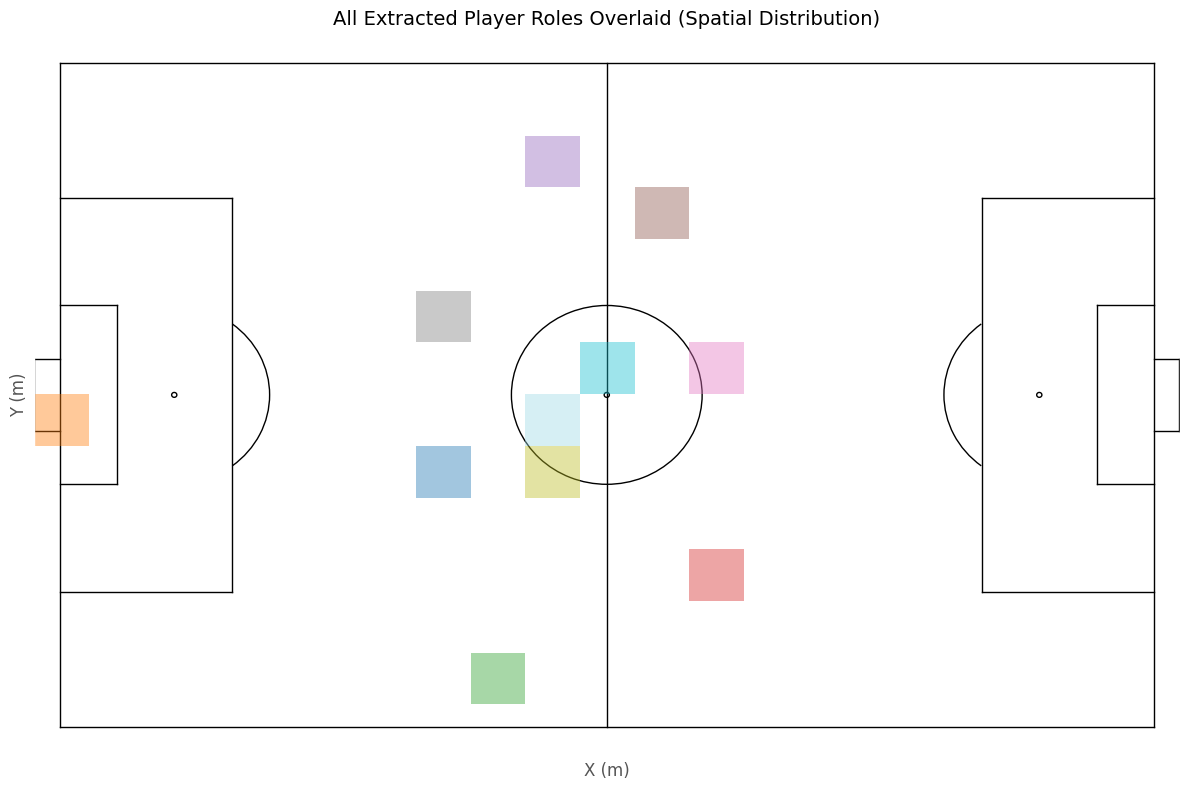

In [5]:
# Plot all role heatmaps overlaid in a single figure
role_heatmaps = get_role_heatmaps(results['B'], results['grid_shape'], top_k=2)
n_roles = results['n_roles']

# Position labels for 4-2-3-1 formation
position_labels = ["TW", "LV", "IVL", "RV", "IVR", "DML", "DMR", "ORM", "OLM", "ZO", "STZ"]
# Position labels for 3-3-2-2- formation
# position_labels = ['TW', 'IVL', 'IVZ', 'IVR', 'DLM', 'DMZ', 'DRM', 'HL', 'HR', 'STL', 'STR']
player_labels = [f"{pos}" for pos in position_labels] + [f"Away {pos}" for pos in position_labels]

# Create a mapping from role to the player position(s) assigned to it
player_role_assignments = results['player_role_assignments']
role_to_players = {k: [] for k in range(n_roles)}
for player_idx, role in enumerate(player_role_assignments):
    if player_idx < len(player_labels):
        role_to_players[role].append(player_labels[player_idx])

# Hardcoded limit values from y_lim and x_lim in Pitch
x_min, x_max = -55, 55
y_min, y_max = -37, 37

# Create a single figure
fig, ax = plt.subplots(figsize=(12, 8))
pitch.plot(ax=ax, color_scheme="bw")
ax.set_facecolor("#202f1f00") #202f1f
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
# ax.annotate("Attacking Direction", xy=(-51, -25), xytext=(-51, -28), xycoords="data", fontsize=12, color='white')
# ax.annotate("", xy=(-22, -25), xytext=(-51, -25), xycoords="data",
#             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), ha="center", va="top")

# Use a qualitative colormap with distinct colors for each role
colors = plt.cm.tab20(np.linspace(0, 1, n_roles))

# Overlay all heatmaps with different colors
for k, heatmap in enumerate(role_heatmaps):
    # Create a masked array where NaN values are masked
    masked_heatmap = np.ma.masked_invalid(heatmap)

    # Get player position label
    # Create a custom colormap for this role (single color with varying alpha)
    from matplotlib.colors import LinearSegmentedColormap
    role_color = colors[k]
    cmap_colors = [(role_color[0], role_color[1], role_color[2], 0),  # transparent
                   (role_color[0], role_color[1], role_color[2], 0.7)]  # opaque
    role_cmap = LinearSegmentedColormap.from_list(f'role_{k}', cmap_colors)
    
    # Plot the heatmap
    ax.imshow(masked_heatmap, origin='lower', cmap=role_cmap, aspect='auto', alpha=0.6,
              extent=(x_min, x_max, y_min, y_max))

# Create a legend for the roles with correct player position assignments
# from matplotlib.patches import Patch
# legend_patches = [
#     Patch(facecolor=colors[k], label=f'Role {k} ({", ".join(role_to_players[k]) if role_to_players[k] else "Unassigned"})', alpha=0.7) 
#     for k in range(n_roles)
# ]
# ax.legend(handles=legend_patches, loc='upper right', fontsize=8, ncol=2)

ax.set_title('All Extracted Player Roles Overlaid (Spatial Distribution)', fontsize=14)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

plt.tight_layout()
plt.show()

## Plot assigned roles per player

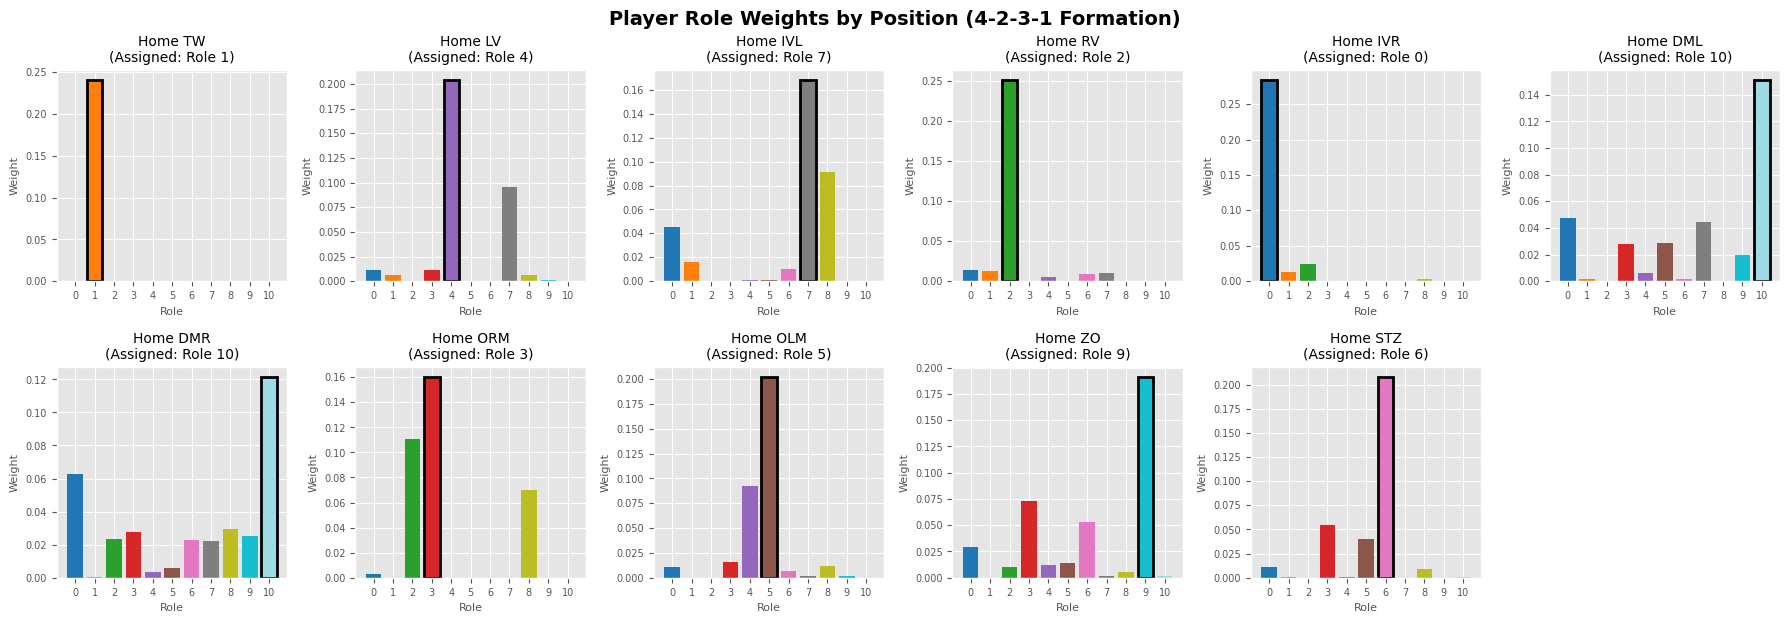

Number of players: 11
Number of roles (K): 11
Number of bins (L): 294
Grid shape: (14, 21)
Reconstruction error: 0.0995

PLAYER ROLE ASSIGNMENT SUMMARY
Player Index    Position        Assigned Role   Max Weight     
------------------------------------------------------------
0               Home TW         1               0.2402         
1               Home LV         4               0.2036         
2               Home IVL        7               0.1680         
3               Home RV         2               0.2503         
4               Home IVR        0               0.2835         
5               Home DML        10              0.1509         
6               Home DMR        10              0.1214         
7               Home ORM        3               0.1602         
8               Home OLM        5               0.2022         
9               Home ZO         9               0.1910         
10              Home STZ        6               0.2078         


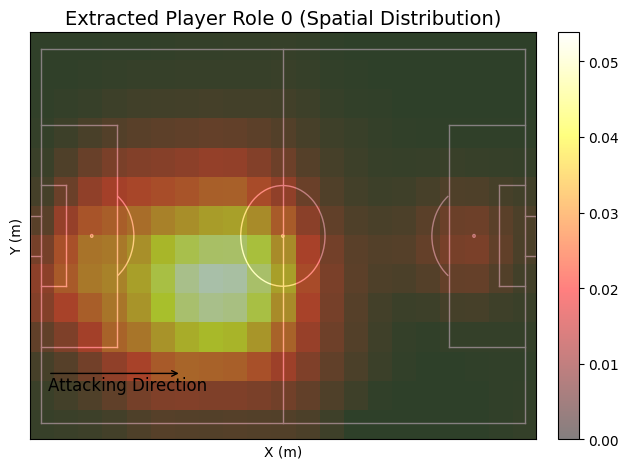

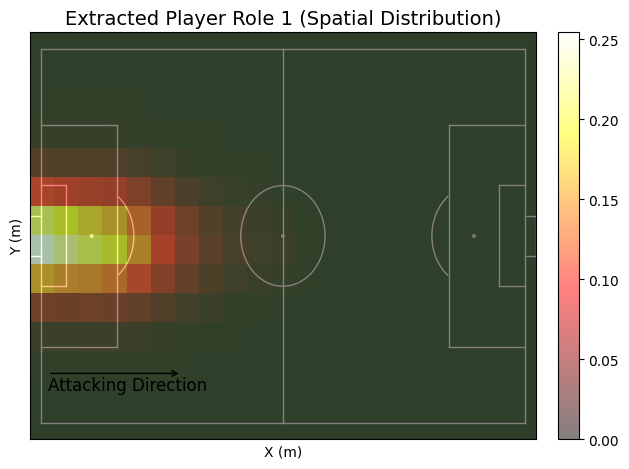

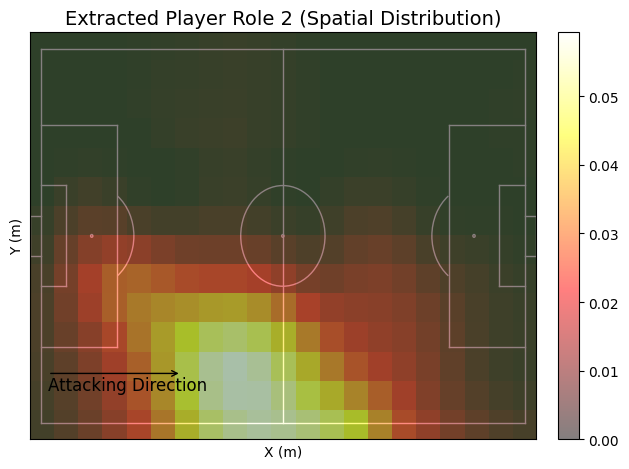

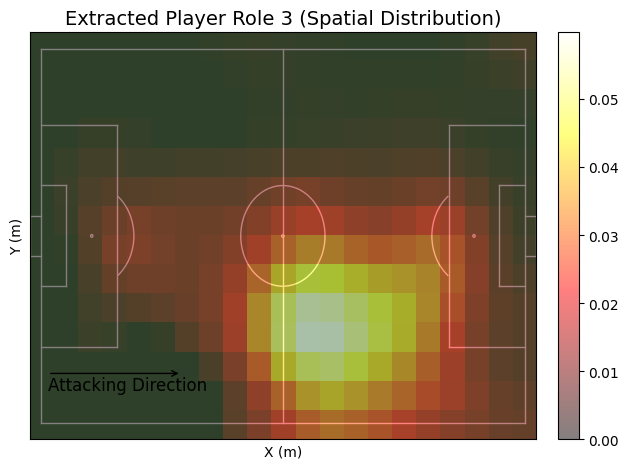

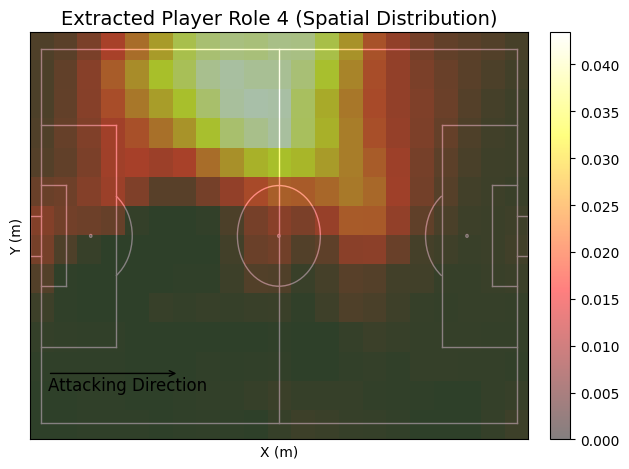

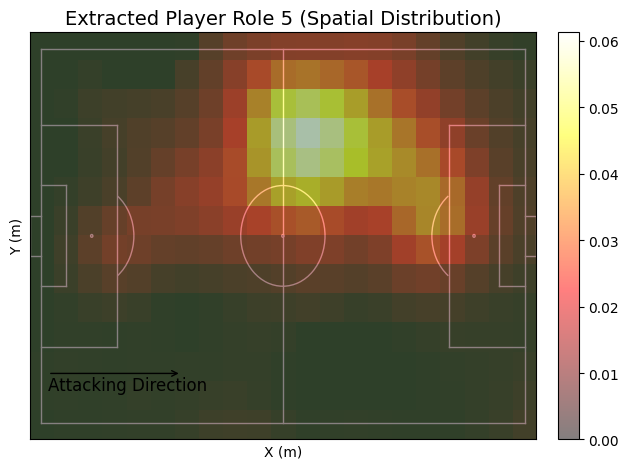

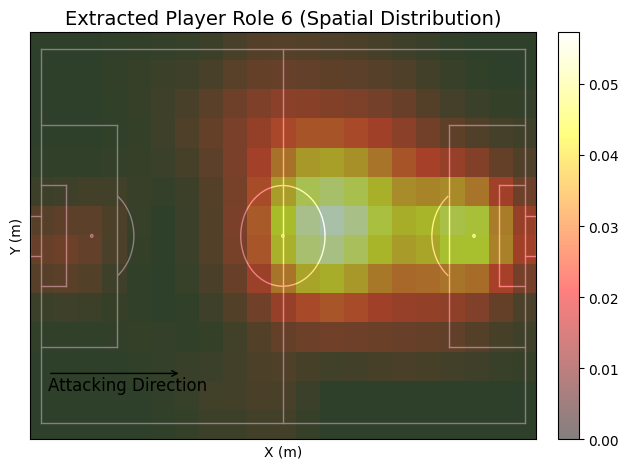

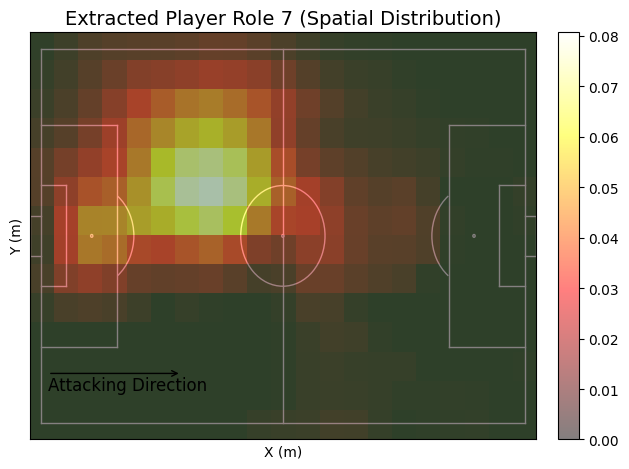

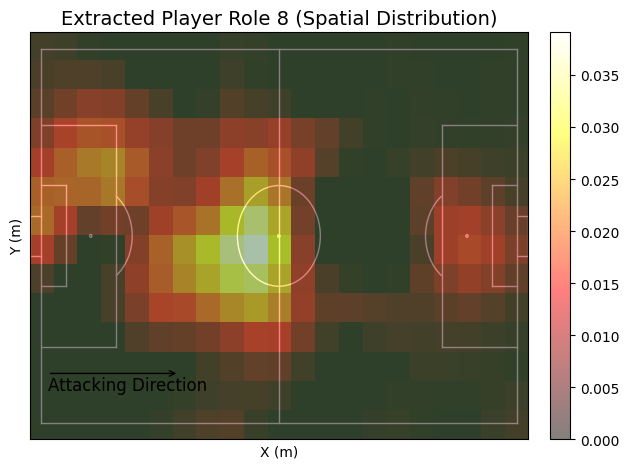

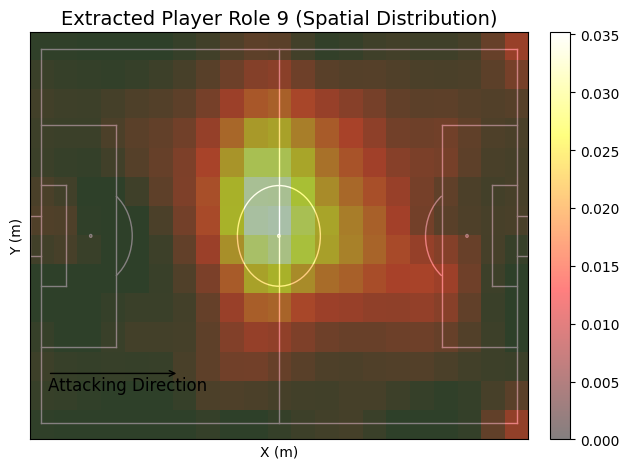

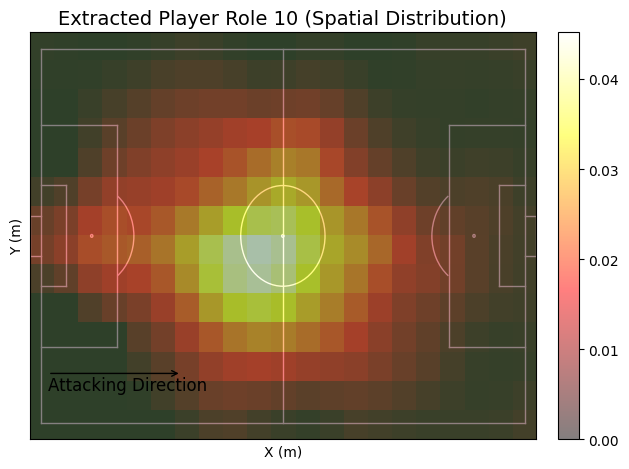

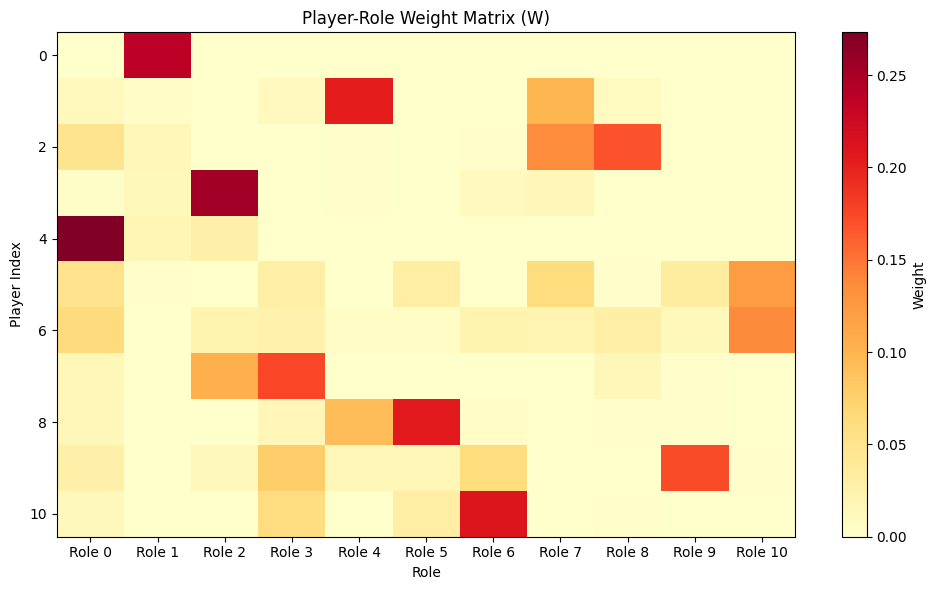

In [ ]:
# Plot assigned roles for each player with their position labels
import matplotlib.pyplot as plt

# Position labels for 4-2-3-1 formation (same order as in group_formations.py)
position_labels = ["TW", "LV", "IVL", "RV", "IVR", "DML", "DMR", "ORM", "OLM", "ZO", "STZ"]
# Position labels for 3-3-2-2 formation 
# position_labels = ['TW', 'IVL', 'IVZ', 'IVR', 'DLM', 'DMZ', 'DRM', 'HL', 'HR', 'STL', 'STR']
# We have 22 players (11 per team), so duplicate labels for both teams
player_labels = [f"Home {pos}" for pos in position_labels] + [f"Away {pos}" for pos in position_labels]

# Get the weight matrix and role assignments
W = results['W']
n_players = results['n_players']
n_roles = results['n_roles']
player_role_assignments = results['player_role_assignments']

# Create a figure with subplots for each player
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(18, 12))
axes = axes.flatten()

# Color map for consistent role colors

eth_colors = [
    "#215CAF",  # ETH Blue
    "#8E6713",  # ETH Bronze
    "#627313",  # ETH Green
    "#007894",  # ETH Petrol
    "#A7117A",  # ETH Purple
    "#6F6F6F",  # ETH Grey
    "#D2C2A1",  # ETH Bronze 40%
    "#A6BEDF",  # ETH Blue 40%
    "#C0C7A1",  # ETH Green 40%
    "#DC9EC9",  # ETH Purple 40%
    "#B7352D",  # ETH Red

]
colors = eth_colors
# colors = plt.cm.tab20(np.linspace(0, 1, n_roles))

for player_idx in range(min(n_players, 22)):  # Show up to 22 players
    ax = axes[player_idx]

    # Get role weights for this player
    role_weights = W[player_idx, :]
    dominant_role = player_role_assignments[player_idx]

    # Create bar plot
    bars = ax.bar(range(n_roles), role_weights, color=colors)

    # Highlight the dominant role
    bars[dominant_role].set_edgecolor('black')
    bars[dominant_role].set_linewidth(2)

    # Set labels
    ax.set_title(f'{player_labels[player_idx]}\n(Assigned: Role {dominant_role})', fontsize=10)
    ax.set_xlabel('Role', fontsize=8)
    ax.set_ylabel('Weight', fontsize=8)
    ax.set_xticks(range(n_roles))
    ax.set_xticklabels([str(k) for k in range(n_roles)], fontsize=7)
    ax.tick_params(axis='y', labelsize=7)

# Hide any unused subplots
for idx in range(n_players, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Player Role Weights by Position (4-2-3-1 Formation)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Create a summary table
print("\n" + "=" * 60)
print("PLAYER ROLE ASSIGNMENT SUMMARY")
print("=" * 60)
print(f"{'Player Index':<15} {'Position':<15} {'Assigned Role':<15} {'Max Weight':<15}")
print("-" * 60)
for player_idx in range(n_players):
    pos = player_labels[player_idx] if player_idx < len(player_labels) else f"Player {player_idx}"
    assigned_role = player_role_assignments[player_idx]
    max_weight = W[player_idx, assigned_role]
    print(f"{player_idx:<15} {pos:<15} {assigned_role:<15} {max_weight:<15.4f}")


## Plot all roles individually

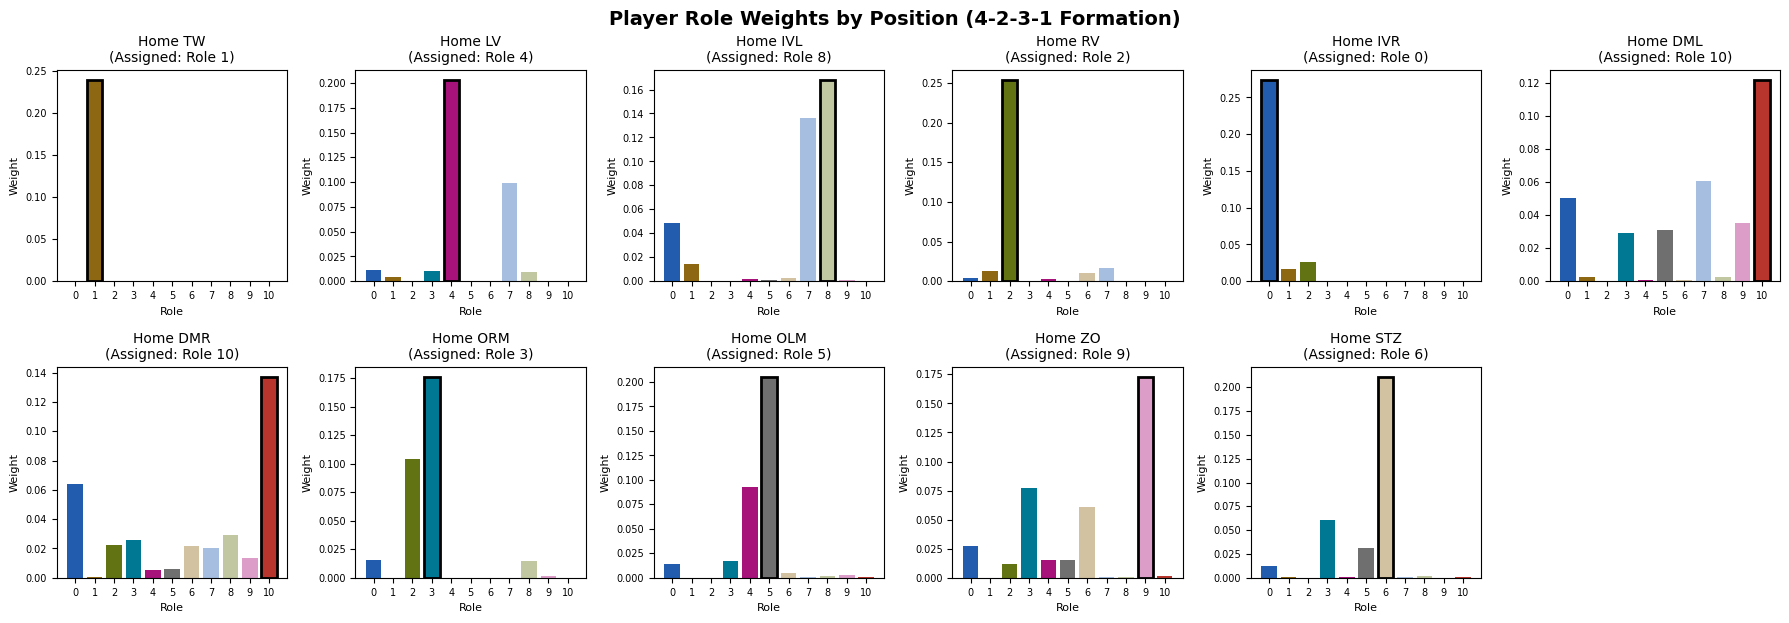

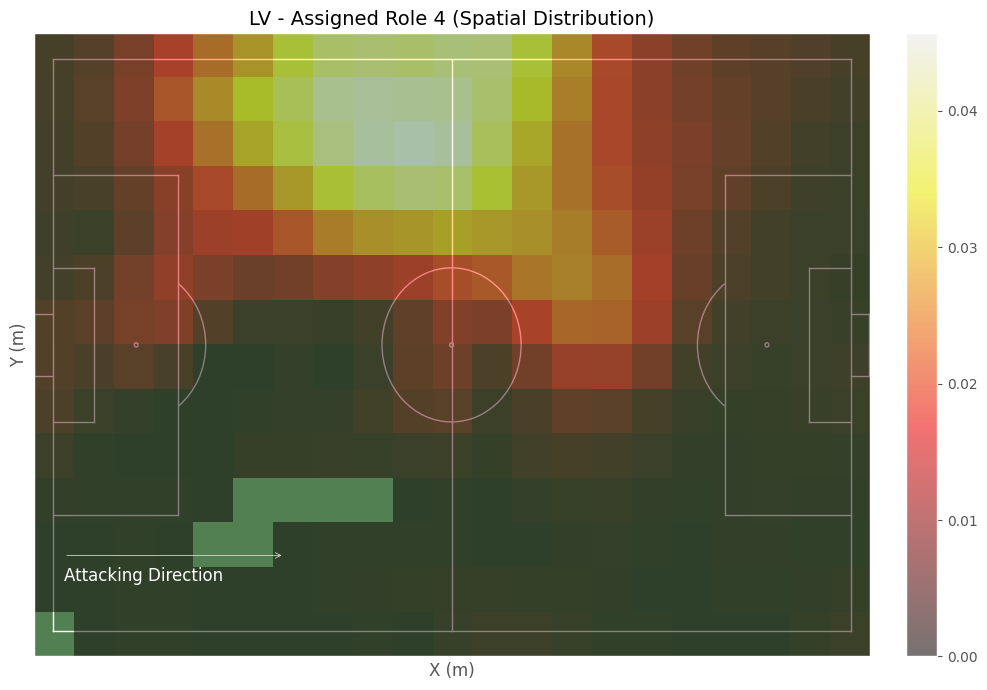

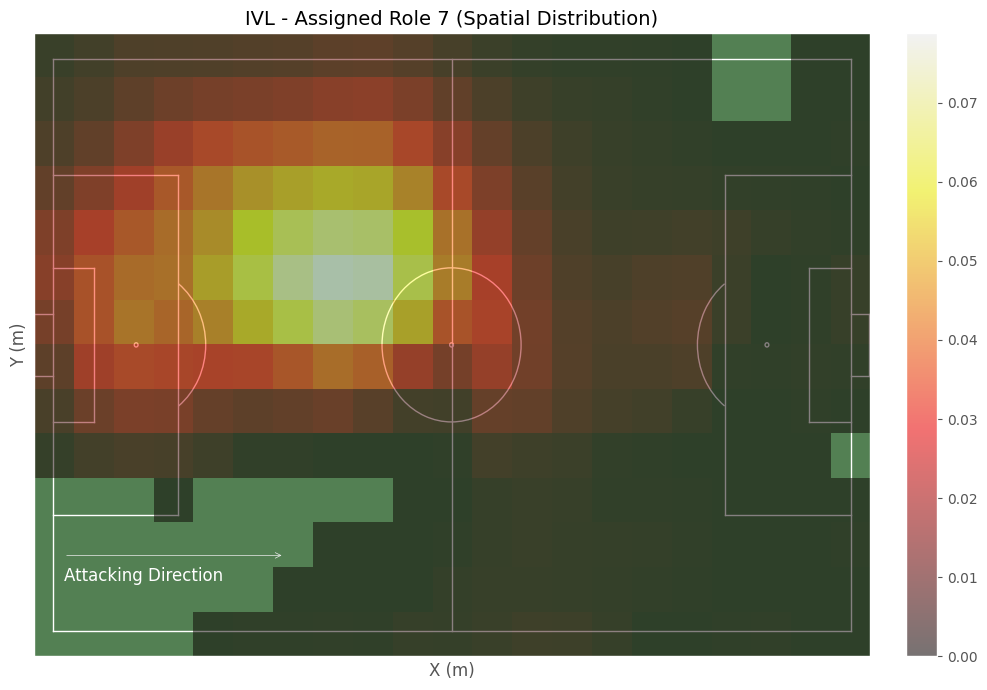

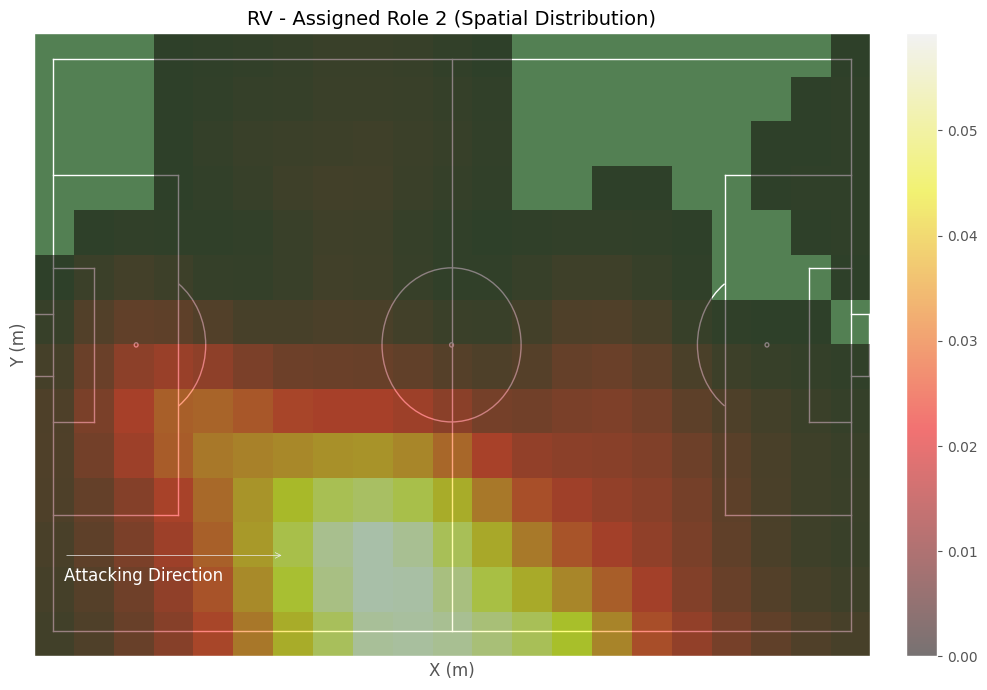

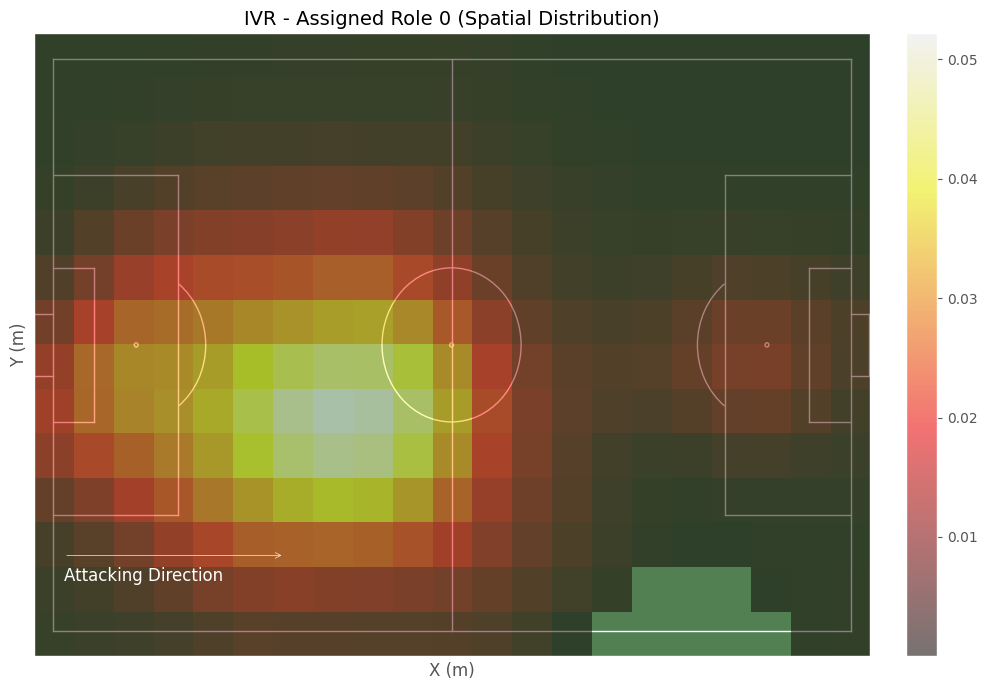

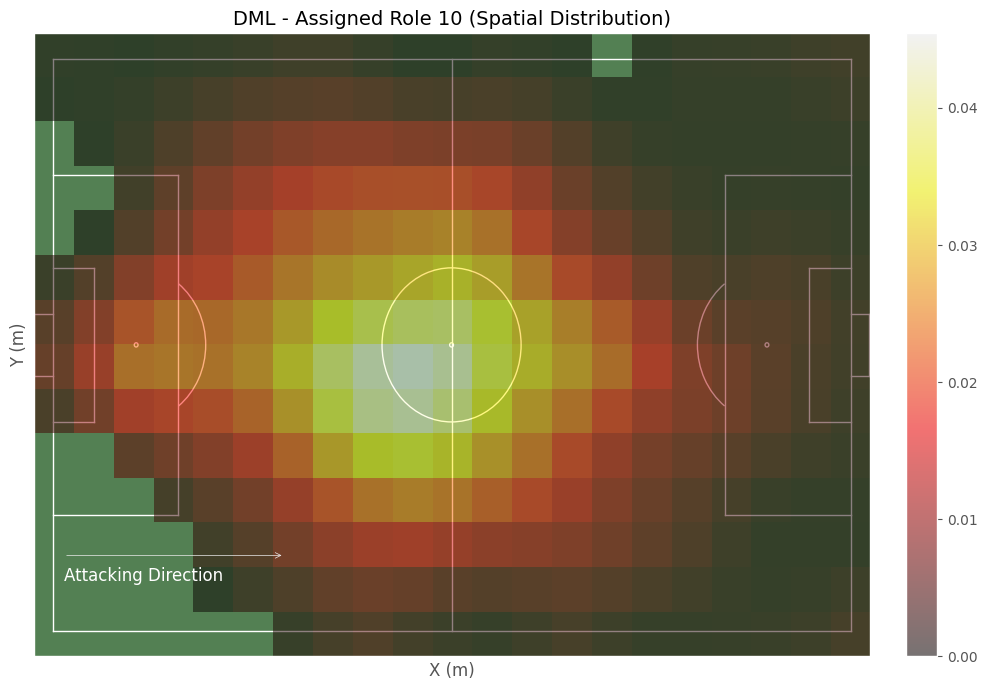

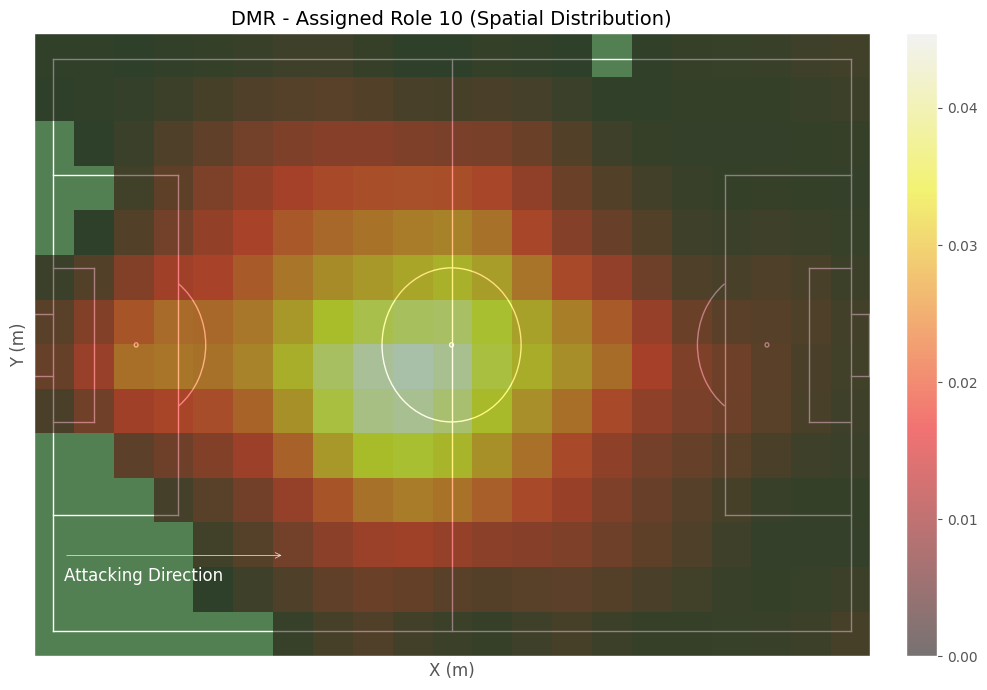

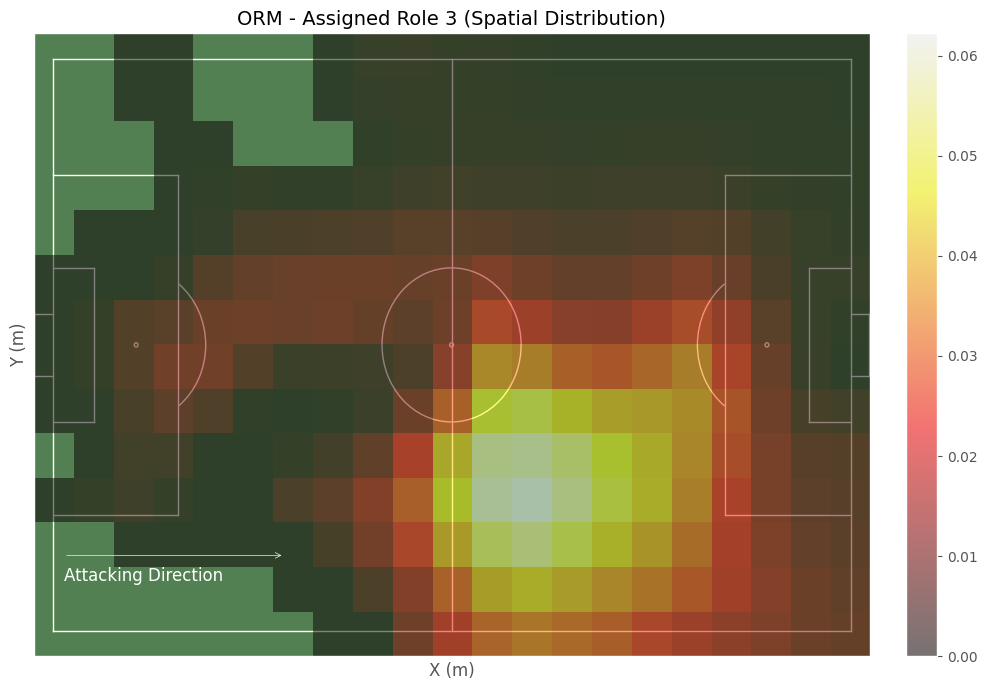

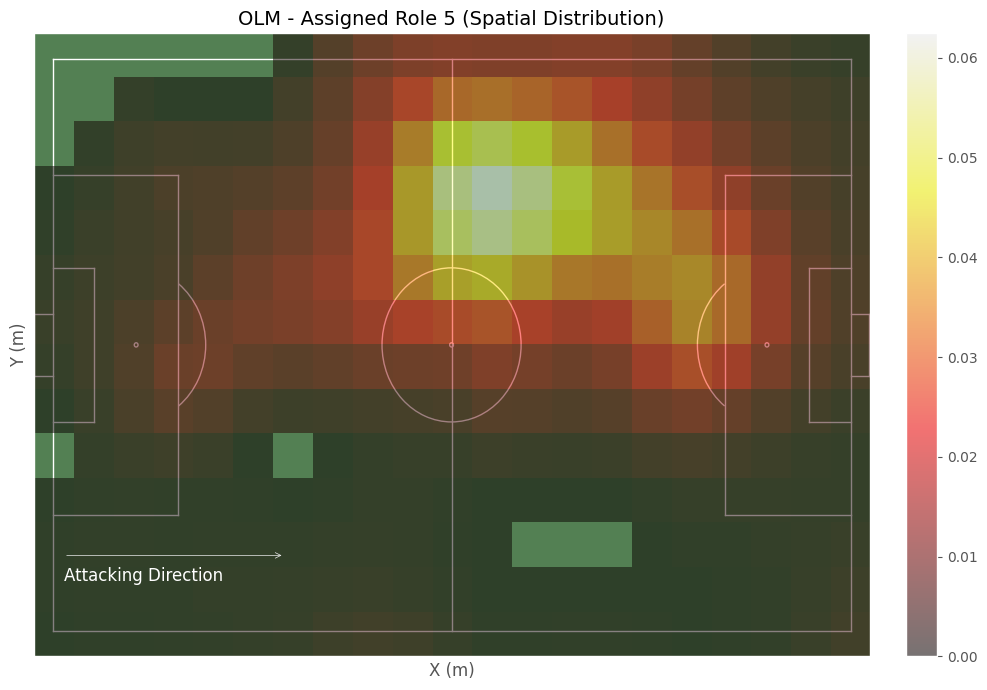

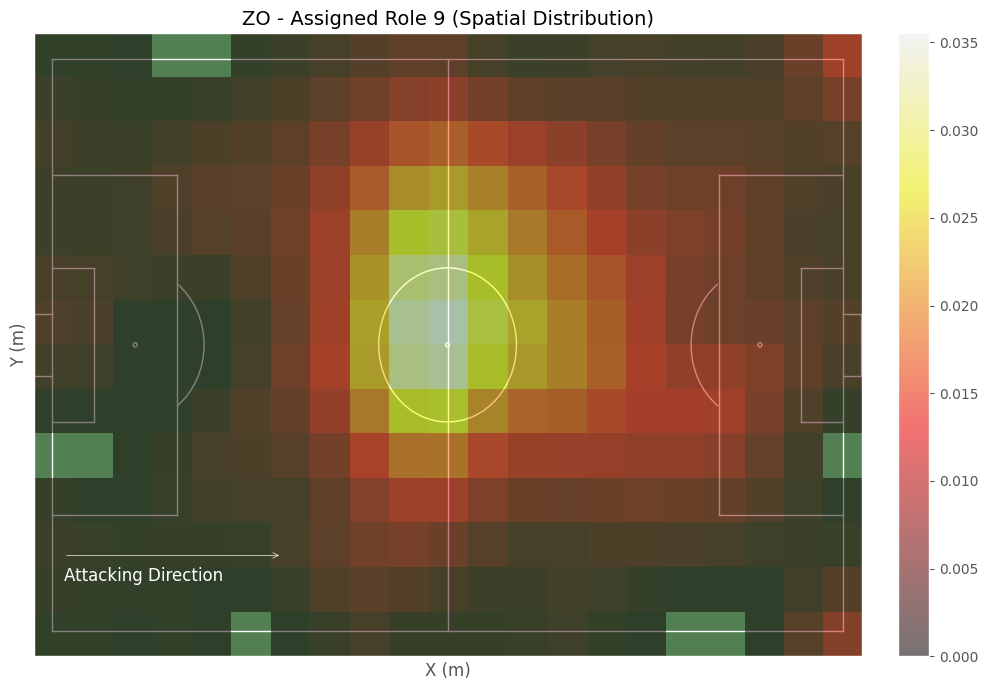

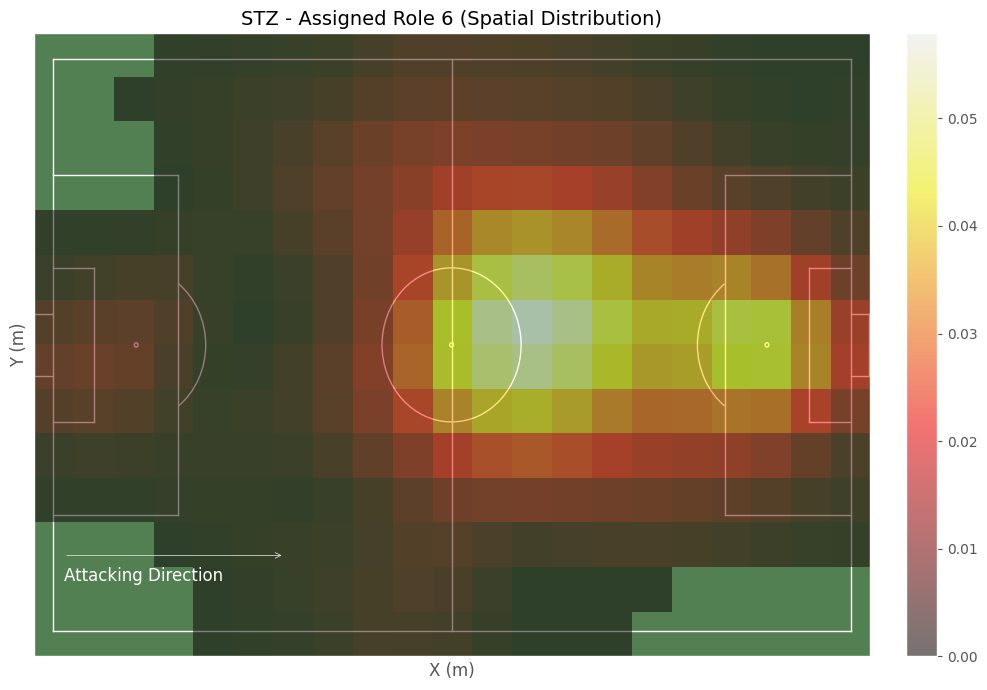

In [ ]:
# Plot the top assigned role heatmap for each player with their position in the title
# Use percentile=90 to show only significant blocks
role_heatmaps = get_role_heatmaps(results['B'], results['grid_shape'], percentile=0)

# Position labels for 4-2-3-1 formation
position_labels = ["TW", "LV", "IVL", "RV", "IVR", "DML", "DMR", "ORM", "OLM", "ZO", "STZ"]
# Position labels for 3-3-2-2 formation
# position_labels = ['TW', 'IVL', 'IVZ', 'IVR', 'DLM', 'DMZ', 'DRM', 'HL', 'HR', 'STL', 'STR']
player_labels = [f"{pos}" for pos in position_labels] + [f"Away {pos}" for pos in position_labels]

# Iterate through each player and plot their top role heatmap
for player_idx in range(min(results['n_players'], 22)):
    # Get the dominant role for this player
    dominant_role = results['player_role_assignments'][player_idx]
    heatmap = role_heatmaps[dominant_role]

    # Get player position label
    player_pos = player_labels[player_idx] if player_idx < len(player_labels) else f"Player {player_idx}"

    # Hardcoded limit values from y_lim and x_lim in Pitch
    x_min, x_max = -55, 55
    y_min, y_max = -37, 37

    # Custom cmap 
    original_cmap = plt.cm.get_cmap('hot')
    transparent_cmap = original_cmap
    transparent_cmap.set_bad(color=(0, 0, 0, 0))

    fig, ax = plt.subplots(figsize=(10, 7))
    pitch.plot(ax=ax)
    ax.set_facecolor('#538053')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.annotate("Attacking Direction", xy=(-51, -25), xytext=(-51, -28), xycoords="data", fontsize=12, color='white')
    ax.annotate("", xy=(-22, -25), xytext=(-51, -25), xycoords="data",
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), ha="center", va="top")

    # The heatmap is plotted on top with alpha for transparency
    im = ax.imshow(heatmap, origin='lower', cmap=transparent_cmap, aspect='auto', alpha=0.5,
                   extent=(x_min, x_max, y_min, y_max))

    ax.set_title(f'{player_pos} - Assigned Role {dominant_role} (Spatial Distribution)', fontsize=14)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')

    # Add colorbar for this plot
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Adjust layout and show the individual figure
    plt.tight_layout()
    plt.show()

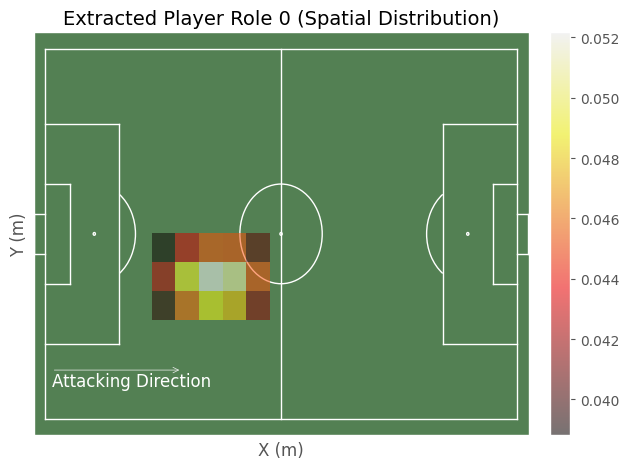

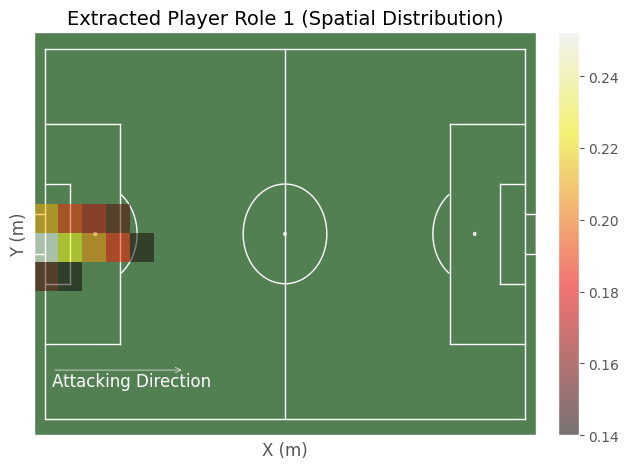

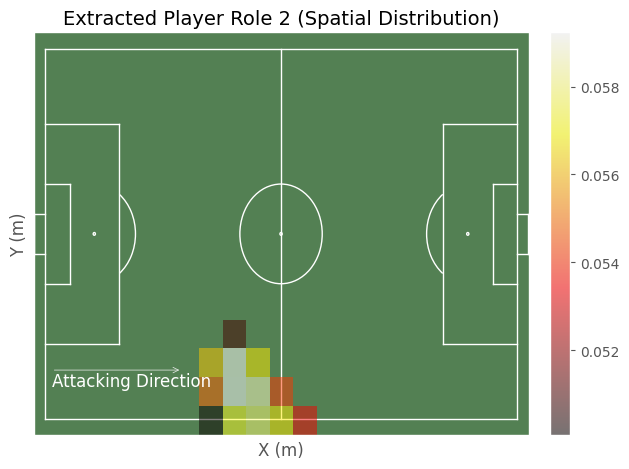

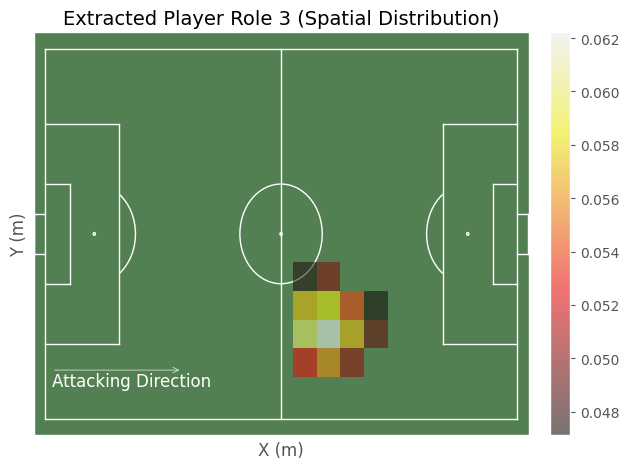

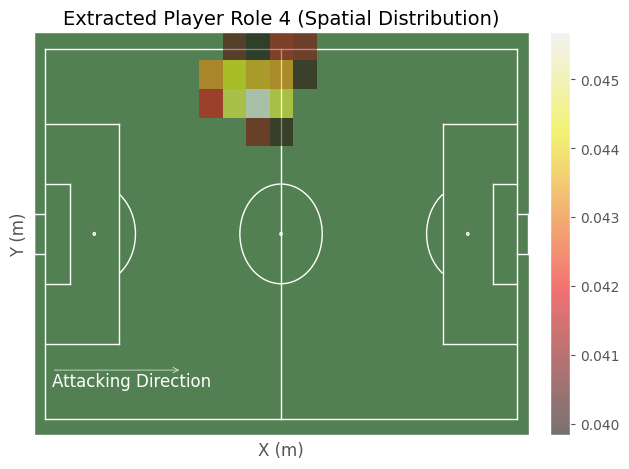

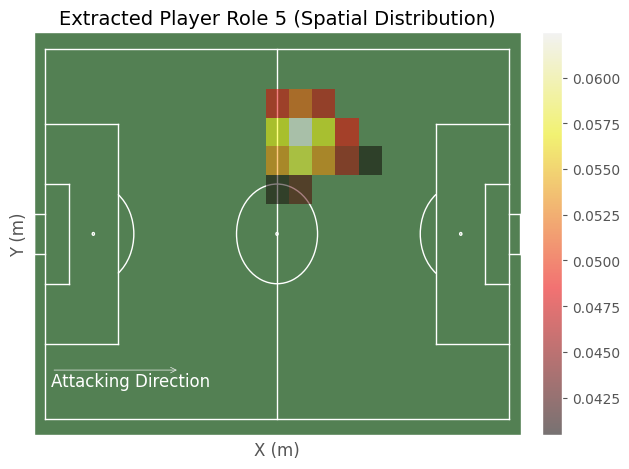

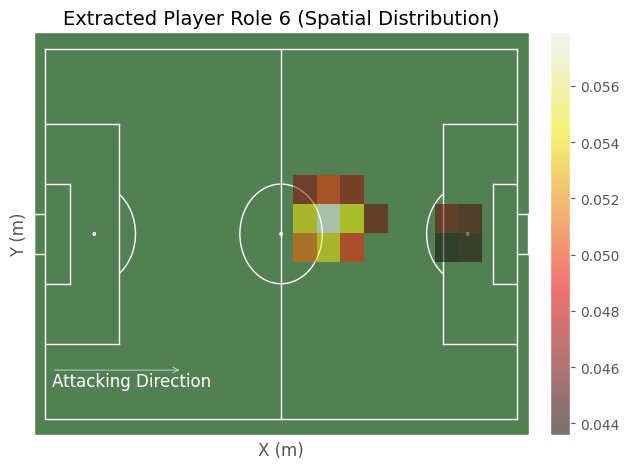

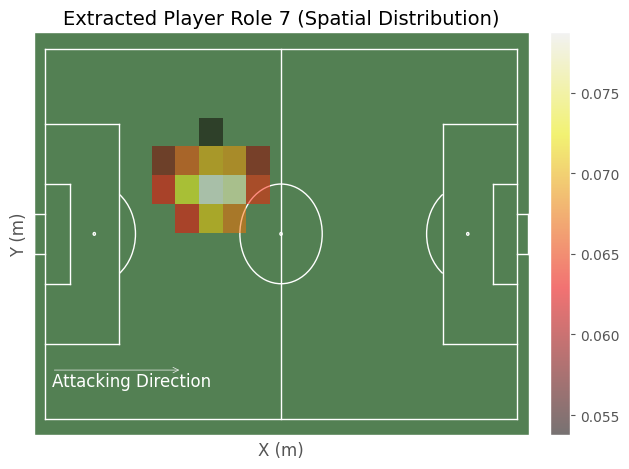

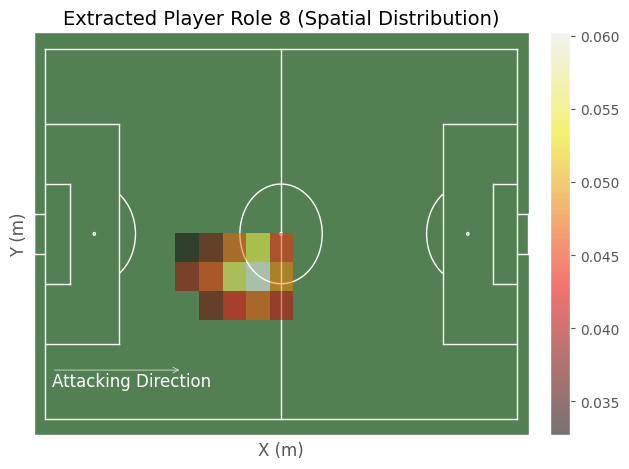

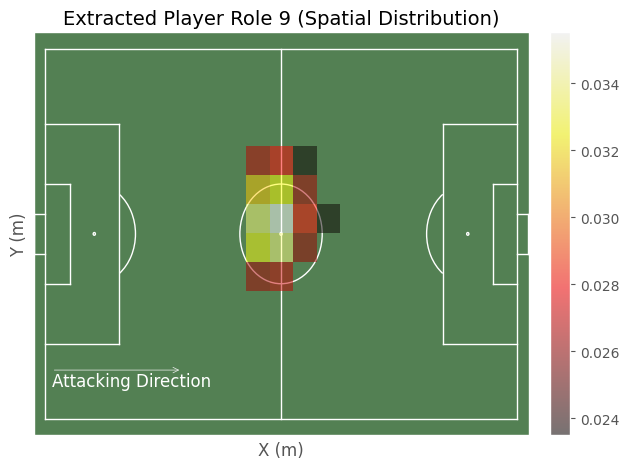

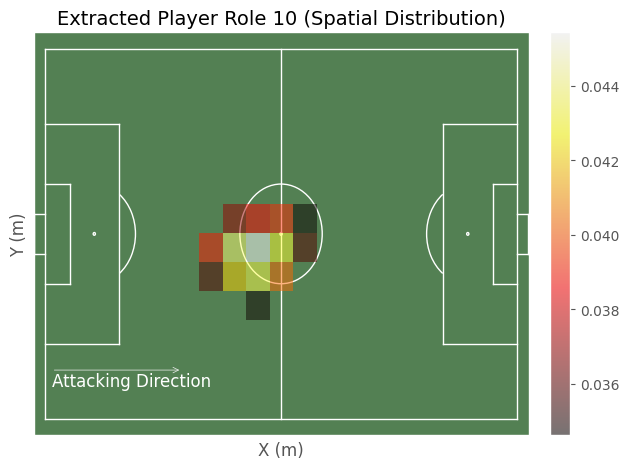

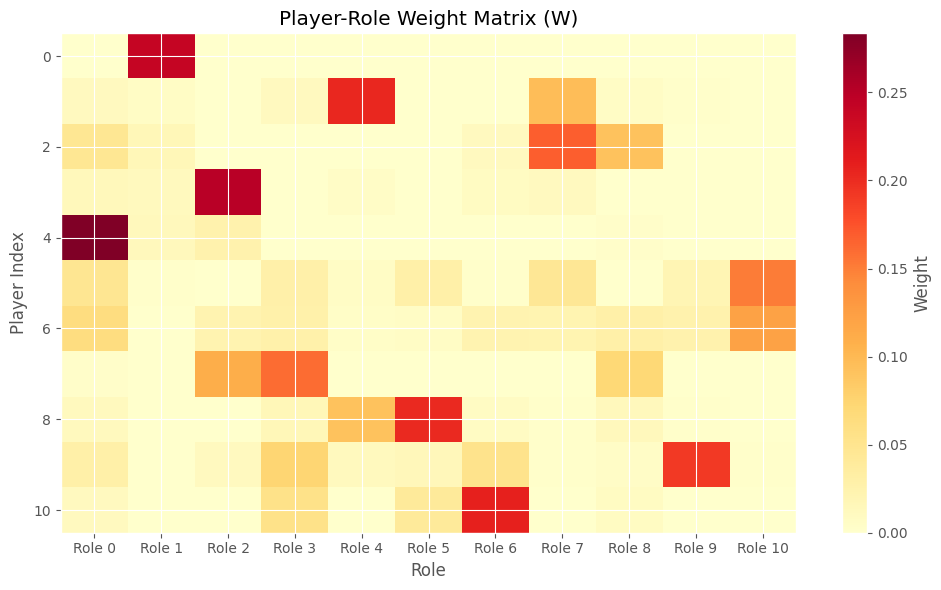

In [8]:
# Get role heatmaps with thresholding - only show values above 90th percentile
# This keeps only the most significant blocks/elements
role_heatmaps = get_role_heatmaps(results['B'], results['grid_shape'], percentile=95)
n_roles = results['n_roles'] # Get the total number of roles

# Iterate through the heatmaps and plot each one in its own figure
for k, heatmap in enumerate(role_heatmaps):
    # Hardcoded limit values from y_lim and x_lim in Pitch
    x_min, x_max = -55, 55
    y_min, y_max = -37, 37
    # Custom cmap 
    original_cmap = plt.cm.get_cmap('hot') 
    transparent_cmap = original_cmap
    transparent_cmap.set_bad(color=(0, 0, 0, 0))
    
    fig, ax = plt.subplots() # Adjust figsize as needed for a single plot
    pitch.plot(ax=ax)
    ax.set_facecolor('#538053')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.annotate("Attacking Direction", xy=(-51, -25), xytext=(-51, -28), xycoords="data", fontsize=12, color='white')
    ax.annotate("", xy=(-22, -25), xytext=(-51, -25), xycoords="data",
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), ha="center", va="top")
    # The heatmap is plotted on top with alpha for transparency
    im = ax.imshow(heatmap, origin='lower', cmap=transparent_cmap, aspect='auto', alpha=0.5, 
                extent=(x_min, x_max, y_min, y_max))
    
    ax.set_title(f'Extracted Player Role {k} (Spatial Distribution)', fontsize=14)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')

    # 5. Add colorbar for this plot
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # 6. Adjust layout and show the individual figure
    plt.tight_layout()
    plt.show()


# Visualize player-role weight matrix (This part remains a single plot)
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(results['W'], cmap='YlOrRd', aspect='auto')
ax.set_xlabel('Role')
ax.set_ylabel('Player Index')
ax.set_title('Player-Role Weight Matrix (W)')
ax.set_xticks(range(results['n_roles']))
ax.set_xticklabels([f'Role {k}' for k in range(results['n_roles'])])
plt.colorbar(im, ax=ax, label='Weight')
plt.tight_layout()
plt.show()